<h1>Overview</h1>

The recommender system that is being designed is meant to be able to predict which machine learning algorithm best predicts a given molecule. This is notebook is designed to go over the nomenclature for the recommender system, the method used for generating the results from the recommender system, and the analysis of the recommender results. 

<h2>Nomenclature</h2>

__Model__ - Machine learning algorithm <br>
__Average Predicted Error__ - Average absoulate error for a molecule predicted by a model. <br>
__Control Smiles__ - Smiles randomly choosen from the dataset used. <br>
__Similiarity Algorithm__ - An algorithm to find how similiar two molecules are, either rdkit, hyer, or jaccard. <br>
__Similiarity Score__ - The numerical value generated from a similiarity algorithm. <br>
__\<Algorithm\> Similiar Molecules__ - The top 5 molecules that are most similiar to the control smiles based on a given similiarity algorithm. <br>
__All Similiar Molecules__ - The 5-15 molecules that include all the unqiue molecules from the top 5 most similiar molecules to the control smiles from each of the 3 similiarity algorithms. <br>
__Test Smiles__ - All similiar molecules plus control smiles for a total of 6-16 smiles. These smiles are forced into the test to ensure models do not train on testing molecules. <br>
__Model List__ - The list containing how well a given model predicted a molecule order from lowest predicted error to highest. For example, if there are three models {svm, gdb, nn} and for a given molecule it was predicted best by the nn model, then the gdb model, then worst by the svm model. The model list for the given molecule would be [nn, gdb, svm]. <br>
__List Score__ - The numeric value for how similiar the model list for the control smiles is to the model list for a test smiles. The list score is between 0 and 1, 1 being identical and 0 being completely dissimliar. <br>
__Average List Score__ - The average list score for each of the similiar molecules for a given similiarity algorithm. <br>
__Ground truth__ - The model that predicted the control smiles the best. <br>
__Goodness Score__ - The numeric value for how far off the predicted error for the recommended model is from the predicted error from the ground truth. For example, if the ground truth has a predicted error of 0.2 and the recommended model has a predicted error of 0.5, the goodness score would be 0.5-0.2=0.3. The lower the number the better, with 0 being perfect.<br>
__Average Goodness Score__ - The average goodness scores for each of the similiar molecules for an algorithm. <br>
__Runs__ - The number of times the entire method is run. Each run has one control smiles, so the number of runs equals the number of control smiles.

<h2>Method</h2>

The dataset used was Lipophilicity-ID.csv. A new Neo4j graph database was created and the graph database library plugin was added with the password set to 'password'. For each of the 10 runs, a smiles was randomly selected from the lipo dataset and set as the control smiles. The top 5 most similiar molecules were found using each of the 3 similiarity alogorithms for a total of 15 similiar molecules. 18 different models were run for each run using all the combinations of learners=['rf', 'nn', 'gdb'] and features=[[0], [2], [3], [4], [0, 2], [0, 3]]. For each model run, the test smiles were moved to the test set if they were spilt into either the training set or validiation set. Also, the models were run without tuning and with the default settings to save time. After running the models, processing in python is done to calculate the list scores and goodness scores for each test smiles for each control smiles.  

<h2>Analysis</h2>

In [385]:
results_dir = 'results'
dataset = "recommender_test_files/lipo_raw.csv"
target = 'exp'

In [386]:
import os

import pandas as pd


def get_target_value(dataset, target, smiles):
    dataset_df = pd.read_csv(dataset)  # Get Lipo value from dataset
    value = dataset_df.loc[dataset_df['smiles'] == smiles].to_dict('records')[0][target]
    return value


def process_control_smiles(dataset, target, algo, results_dir):
    rows = []
    for directory in os.listdir(results_dir):  # Each directory is a single run and has only one control smiles
        directory = f"{results_dir}/{directory}"
        if os.path.isdir(directory):  # Results files get saved to same directory
            control_smiles = list(pd.read_csv(f"{directory}/control_smiles.csv")['smiles'])[0]
            row_data = {'control_smiles': control_smiles}
            row_data[target] = get_target_value(dataset, target, control_smiles)

            def __galc__():  # get average list score
                df = pd.read_csv(f"{directory}/ratio.csv")
                df = df.loc[df['type'] == algo]
                list_scores = df['ratio_score'].tolist()
                average_list_score = sum(list_scores) / len(list_scores)
                return average_list_score

            def __gagc__():  # get average goodness score
                control_df = pd.read_csv(f"{directory}/control_smiles.csv")
                best_pred_error = control_df.to_dict('records')[0]['pred_error']
                df = pd.read_csv(f"{directory}/{algo}_smiles.csv")
                unqiue_smiles = list(set(df['smiles'].tolist()))  # Only get unqiue smiles
                goodness_scores = []
                for smiles in unqiue_smiles:
                    sub_df = df.loc[df['smiles'] == smiles]
                    testing_bm = sub_df.to_dict('records')[0]['run_name']
                    goodness_score = control_df.loc[control_df['run_name'] == testing_bm]
                    goodness_score = goodness_score.to_dict('records')[0]['pred_error']
                    goodness_score = goodness_score - best_pred_error
                    goodness_scores.append(goodness_score)
                average_goodness_score = sum(goodness_scores) / len(goodness_scores)
                return average_goodness_score

            def __gpr__():  # get percent right
                control_df = pd.read_csv(f"{directory}/control_smiles.csv")
                bm = control_df.to_dict('records')[0]['run_name']  # bm = best model (ground turth)
                df = pd.read_csv(f"{directory}/{algo}_smiles.csv")
                unqiue_smiles = list(set(df['smiles'].tolist()))
                top_list = []
                for smiles in unqiue_smiles:
                    sub_df = df.loc[df['smiles'] == smiles]
                    testing_bm = sub_df.to_dict('records')[0]['run_name']
                    if testing_bm == bm:
                        top_list.append(1)
                    else:
                        top_list.append(0)
                percent_right = sum(top_list) / len(top_list)
                return percent_right

            def __gptt__():  # get percent top three
                control_df = pd.read_csv(f"{directory}/control_smiles.csv")
                bm = control_df.to_dict('records')[0]['run_name']
                df = pd.read_csv(f"{directory}/{algo}_smiles.csv")
                unqiue_smiles = list(set(df['smiles'].tolist()))
                top_list = []
                for smiles in unqiue_smiles:
                    sub_df = df.loc[df['smiles'] == smiles]
                    testing_bms = sub_df['run_name'].tolist()[:3]  # top three models
                    if bm in testing_bms:
                        top_list.append(1)
                    else:
                        top_list.append(0)
                percent_right = sum(top_list) / len(top_list)
                return percent_right

            row_data['list_score'] = __galc__()
            row_data['goodness_score'] = __gagc__()
            row_data['percent_right'] = __gpr__()
            row_data['percent_top_3'] = __gptt__()
            rows.append(row_data)

    algo_df = pd.DataFrame(rows)
    return algo_df

In [387]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def plot(algo, df, x_name, y_name, color=None):
    x = df[x_name]
    y = df[y_name]

    plt.rcParams['figure.figsize'] = [12, 9]
    plt.style.use('bmh')
    fig, ax = plt.subplots()
    if color is not None:
        norm = cm.colors.Normalize(vmax=df[color].max(), vmin=df[color].min())
        plt.scatter(x, y, c=df[color], cmap='plasma', norm=norm, alpha=0.7)
        cbar = plt.colorbar()
        cbar.set_label(color)
    else:
        plt.scatter(x, y, alpha=0.7)
    plt.xlabel(x_name, fontsize=14)
    plt.ylabel(y_name, fontsize=14)
    plt.title(f'{x_name} vs {y_name} ({algo})')
    fig.patch.set_facecolor('blue')  # Will change background color
    fig.patch.set_alpha(0.0)  # Makes background transparent
    plt.show()
    plt.close()

In [388]:
def process_sim_smiles(dataset, target, algo, results_dir):
    rows = []
    for directory in os.listdir(results_dir):  # Each directory is a single run and has only one control smiles
        directory = f"{results_dir}/{directory}"
        if os.path.isdir(directory):  # Results files get saved to same directory
            algo_df = pd.read_csv(f"{directory}/{algo}_smiles.csv")
            unqiue_smiles = list(set(algo_df['smiles'].tolist()))
            row = {}

            def __gsc__(smi):  # get sim score
                df = pd.read_csv(f"{directory}/ratio.csv")
                df = df.loc[df['type'] == algo]
                df = df.loc[df['smiles'] == smi]
                list_score = df.to_dict('records')[0][f'{algo}_similarity']
                return list_score

            def __glc__(smi):  # get list score
                df = pd.read_csv(f"{directory}/ratio.csv")
                df = df.loc[df['type'] == algo]
                df = df.loc[df['smiles'] == smi]
                list_score = df.to_dict('records')[0]['ratio_score']
                return list_score
            
            def __ggc__(smi):  # get goodness score
                control_df = pd.read_csv(f"{directory}/control_smiles.csv")
                best_pred_error = control_df.to_dict('records')[0]['pred_error']
                bm = control_df.to_dict('records')[0]['run_name']  # bm = best model (ground turth)
                df = pd.read_csv(f"{directory}/{algo}_smiles.csv")
                sub_df = df.loc[df['smiles'] == smi]
                testing_bm = sub_df.to_dict('records')[0]['run_name']
                goodness_score = control_df.loc[control_df['run_name'] == testing_bm]
                goodness_score = goodness_score.to_dict('records')[0]['pred_error']
                goodness_score = goodness_score - best_pred_error
                return goodness_score

            for smiles in unqiue_smiles:
                row = {'test_smiles': smiles, target: get_target_value(dataset, target, smiles),
                       'sim score': __gsc__(smiles), 'list score': __glc__(smiles),
                       'goodness score': __ggc__(smiles)}
                rows.append(row)


    algo_df = pd.DataFrame(rows)
    return algo_df

<h2>RDKit Control Smiles</h2>

In [389]:
algo = 'rdkit'
rdkit_results_df = process_control_smiles(dataset, target, algo, results_dir)
rdkit_results_df

,control_smiles,exp,list_score,goodness_score,percent_right,percent_top_3
0,Clc1cc(Nc2ncnc3[nH]nc(OCCN4CCCC4)c23)ccc1OCc1c...,2.87,0.733333,0.303540,0.2,0.4
1,CCN(CC)c1ccc(-c2nn3c(-c4[nH]nc5c4CCC5)nnc3s2)cc1,3.37,0.511111,0.491654,0.4,0.4
2,O=C(O)C[C@@H]1c2ccccc2C[C@H]1NC(=O)c1cc2cc(Cl)...,1.79,0.422222,0.629480,0.0,0.0
3,Cn1c(=O)c(Oc2ccc(F)cc2F)cc2cnc(NC(CCO)CCO)nc21,1.50,0.433333,0.618603,0.0,0.0
4,C[C@H](CO)Nc1nc(SCc2ccco2)nc2[nH]c(=O)sc12,2.21,0.300000,0.210928,0.0,0.0
5,C(#Cc1n[nH]c2ccccc12)c1ccccc1,4.31,0.455556,0.738367,0.4,1.0
6,CCCCCSc1nc(O)c2sc(N)nc2n1,2.86,0.255556,0.476771,0.0,0.0
7,NC(=O)NC(=O)C(Nc1ccc2c(c1)CCC2)c1ccccc1,3.30,0.566667,0.580633,0.0,0.6
8,CCOC(=O)c1cc(O)c(-c2ccccc2)nn1,0.69,0.377778,0.763789,0.0,0.4
9,NC(=O)NC(=O)C(Nc1ccc2c(c1)CCC2)c1ccccc1,3.30,0.533333,0.523334,0.0,0.4


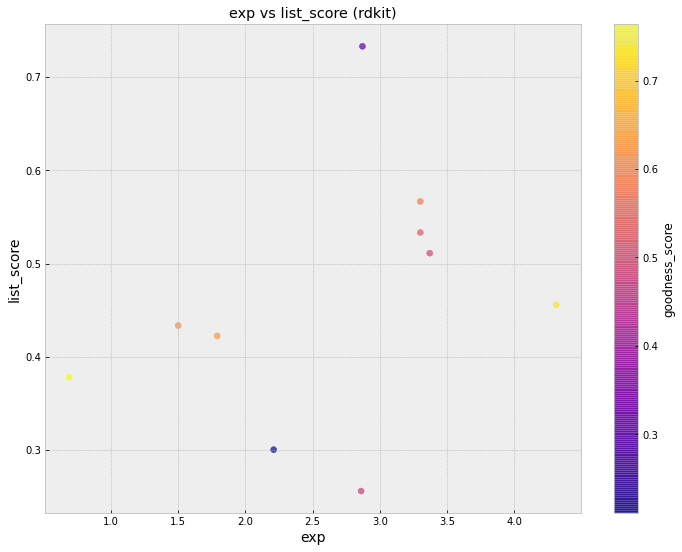

In [390]:
plot(algo, rdkit_results_df, target, 'list_score', color='goodness_score')

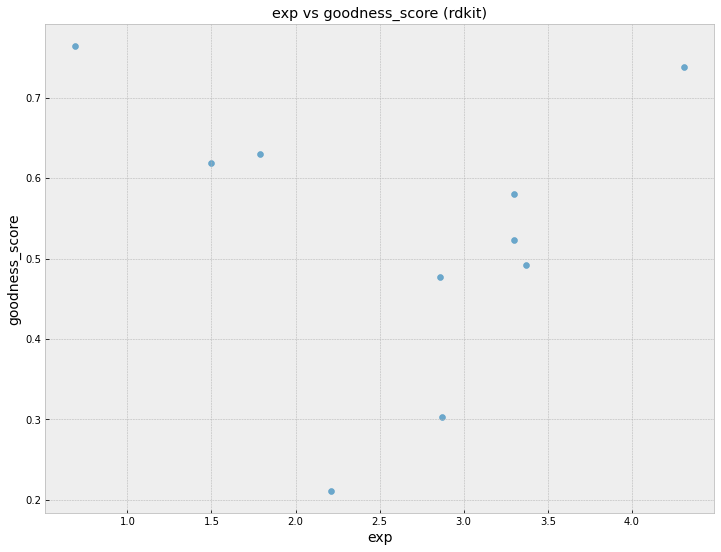

In [391]:
plot(algo, rdkit_results_df, target, 'goodness_score', color=None)

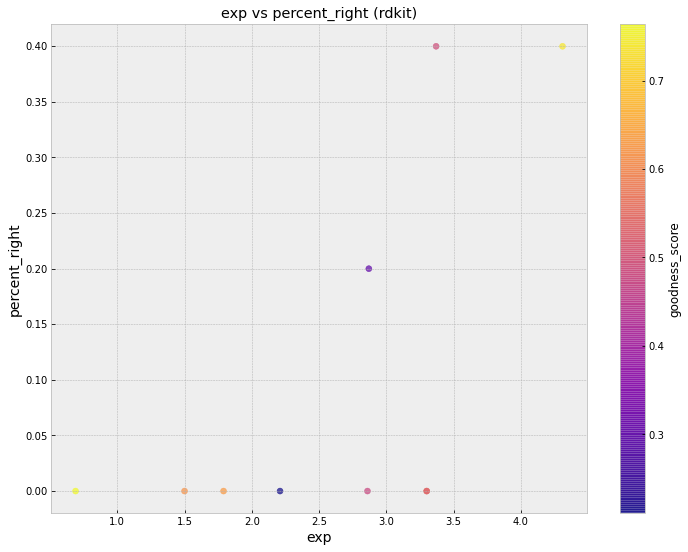

In [392]:
plot(algo, rdkit_results_df, target, 'percent_right', color='goodness_score')

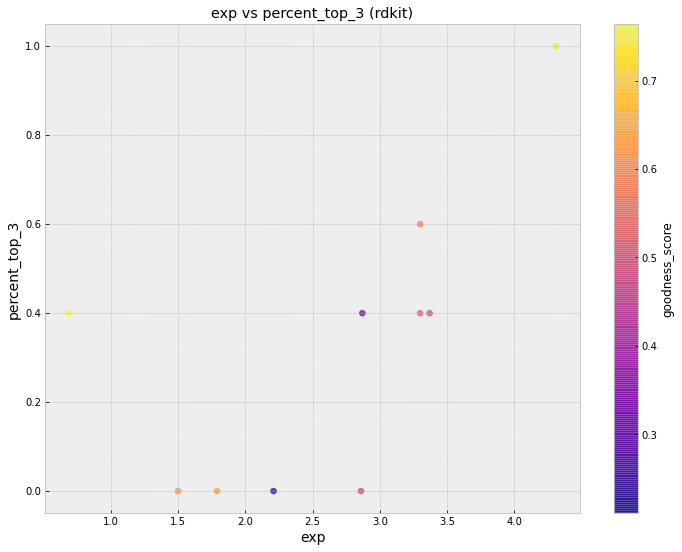

In [393]:
plot(algo, rdkit_results_df, target, 'percent_top_3', color='goodness_score')

<h2>RDKit Testing Smiles</h2>

In [394]:
algo = 'rdkit'
rdkit_sim_results_df = process_sim_smiles(dataset, target, algo, results_dir)
rdkit_sim_results_df.head(20)

,test_smiles,exp,sim score,list score,goodness score
0,C[C@@H](Oc1cccc2ncnc(Nc3ccc(OCc4ccccn4)c(Cl)c3...,3.56,0.636,0.722222,0.419130
1,O=C(CO)N1CCC[C@H]1COc1cccc2ncnc(Nc3ccc(OCc4ccc...,3.62,0.636,0.833333,0.000000
2,Cc1ccc(Oc2ccc(Nc3ncnc4[nH]nc(OCCN5CCC(O)CC5)c3...,3.40,0.816,0.722222,0.339720
3,C[C@H](CN(C)C(=O)CO)Oc1cccc2ncnc(Nc3ccc(OCc4cc...,3.22,0.640,0.722222,0.339720
4,CN1CCN(CCOc2n[nH]c3ncnc(Nc4ccc(OCc5ccccn5)c(Cl...,2.45,0.961,0.666667,0.419130
5,CNc1nc2ccccc2n1Cc1sc2c(c1C(=O)N1C[C@H](O)CO1)c...,1.77,0.568,0.111111,0.569314
6,CCc1nn(C2CCCC2)c2c1CCn1c(-c3cccs3)nnc1-2,3.60,0.598,0.666667,0.000000
7,Cc1oc(S(C)(=O)=O)cc1-c1c2c(=O)n(C)c(=O)n(CC3CC...,4.48,0.570,0.777778,0.000000
8,Oc1ccc2c3c1O[C@H]1c4[nH]c5c(c4C[C@@]4(O)[C@@H]...,1.41,0.585,0.222222,1.466612
9,Oc1ccc2c3c1O[C@H]1c4[nH]c5ccccc5c4C[C@@]4(O)[C...,2.70,0.580,0.777778,0.422347


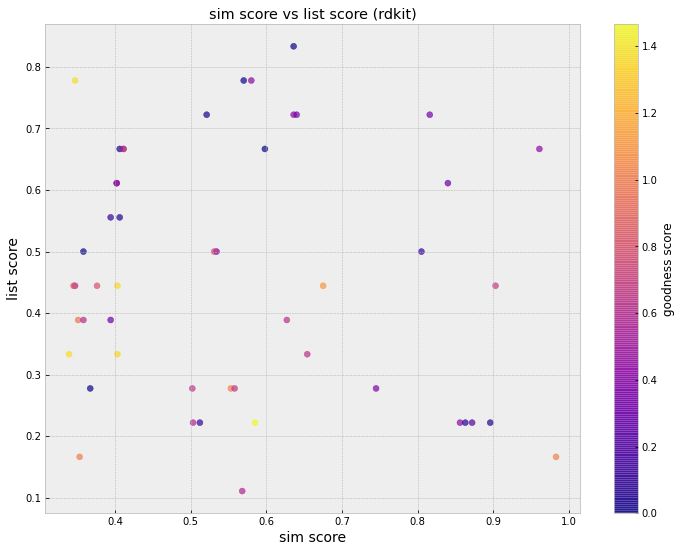

In [395]:
plot(algo, rdkit_sim_results_df, 'sim score', 'list score', color='goodness score')

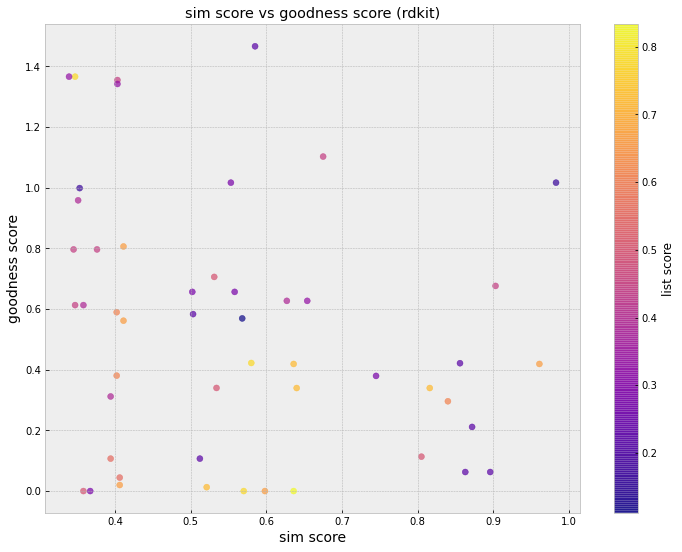

In [396]:
plot(algo, rdkit_sim_results_df, 'sim score', 'goodness score', color='list score')

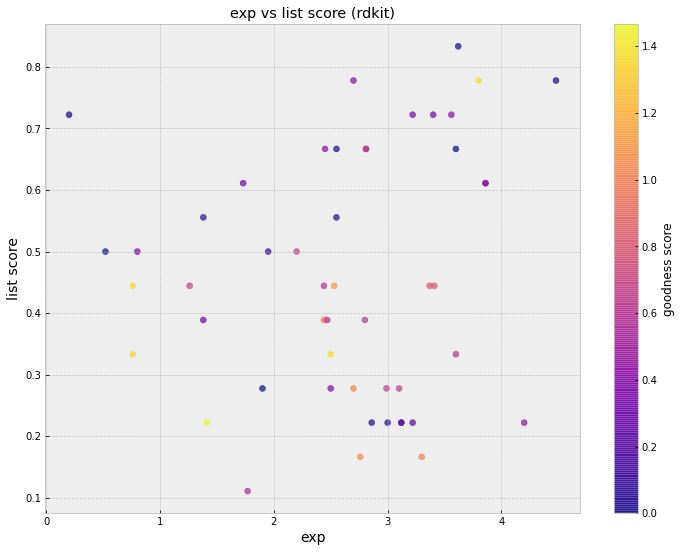

In [397]:
plot(algo, rdkit_sim_results_df, target, 'list score', color='goodness score')

<h2>Jaccard Control Smiles</h2>

In [398]:
algo = 'jaccard'
jaccard_results_df = process_control_smiles(dataset, target, algo, results_dir)
jaccard_results_df

,control_smiles,exp,list_score,goodness_score,percent_right,percent_top_3
0,Clc1cc(Nc2ncnc3[nH]nc(OCCN4CCCC4)c23)ccc1OCc1c...,2.87,0.744444,0.219714,0.4,0.6
1,CCN(CC)c1ccc(-c2nn3c(-c4[nH]nc5c4CCC5)nnc3s2)cc1,3.37,0.611111,0.520560,0.4,0.8
2,O=C(O)C[C@@H]1c2ccccc2C[C@H]1NC(=O)c1cc2cc(Cl)...,1.79,0.411111,0.549639,0.0,0.0
3,Cn1c(=O)c(Oc2ccc(F)cc2F)cc2cnc(NC(CCO)CCO)nc21,1.50,0.288889,0.803939,0.2,0.2
4,C[C@H](CO)Nc1nc(SCc2ccco2)nc2[nH]c(=O)sc12,2.21,0.222222,0.236024,0.0,0.0
5,C(#Cc1n[nH]c2ccccc12)c1ccccc1,4.31,0.611111,0.896255,0.4,0.8
6,CCCCCSc1nc(O)c2sc(N)nc2n1,2.86,0.244444,0.271502,0.0,0.0
7,NC(=O)NC(=O)C(Nc1ccc2c(c1)CCC2)c1ccccc1,3.30,0.244444,0.591136,0.2,0.2
8,CCOC(=O)c1cc(O)c(-c2ccccc2)nn1,0.69,0.255556,0.759744,0.2,0.2
9,NC(=O)NC(=O)C(Nc1ccc2c(c1)CCC2)c1ccccc1,3.30,0.177778,0.688061,0.0,0.0


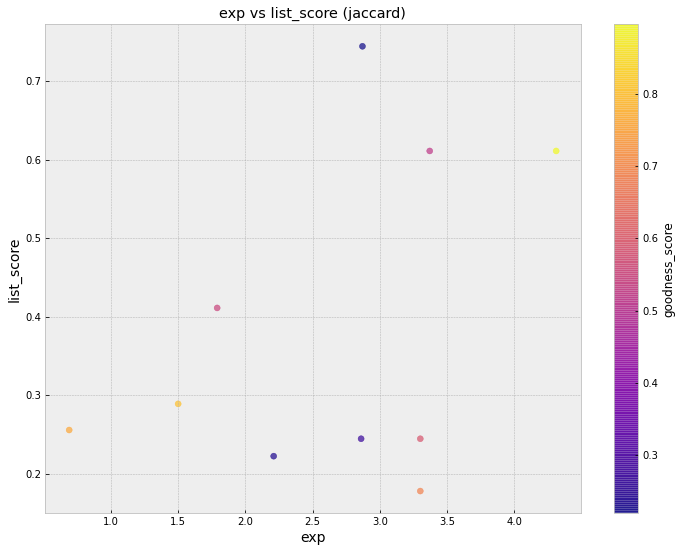

In [399]:
plot(algo, jaccard_results_df, target, 'list_score', color='goodness_score')

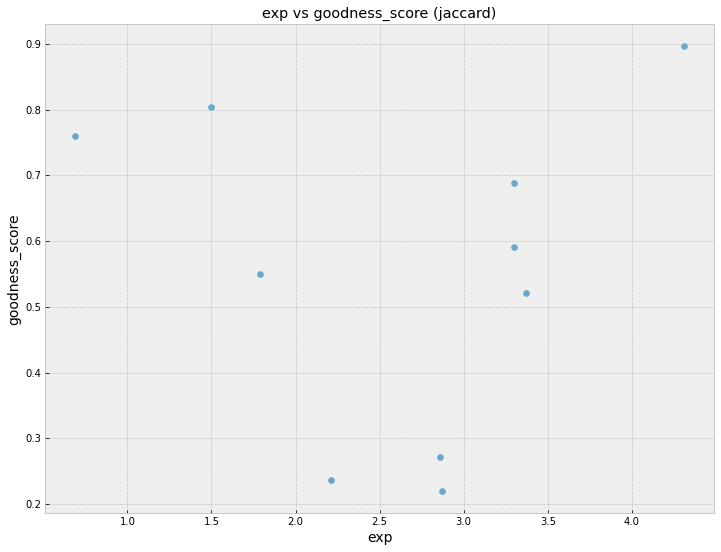

In [400]:
plot(algo, jaccard_results_df, target, 'goodness_score', color=None)

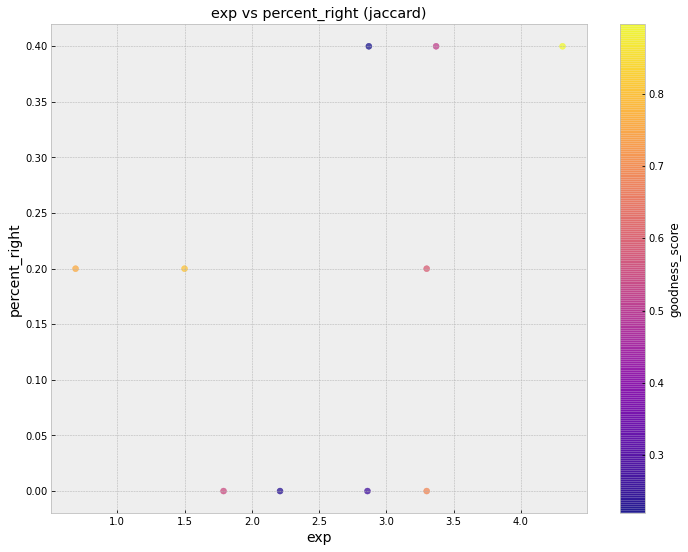

In [401]:
plot(algo, jaccard_results_df, target, 'percent_right', color='goodness_score')

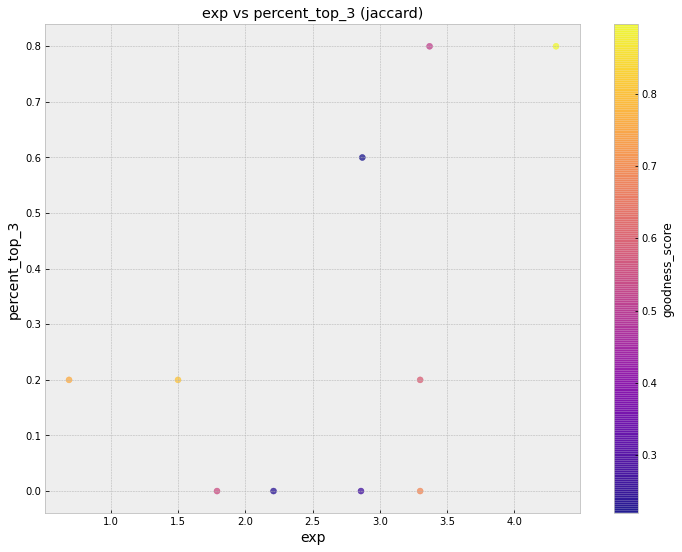

In [402]:
plot(algo, jaccard_results_df, target, 'percent_top_3', color='goodness_score')

<h2>Jaccard Testing Smiles</h2>

In [403]:
algo = 'jaccard'
jaccard_sim_results_df = process_sim_smiles(dataset, target, algo, results_dir)
jaccard_sim_results_df.head(20)

,test_smiles,exp,sim score,list score,goodness score
0,O=C(CO)N1CCC[C@@H]1COc1cccc2ncnc(Nc3ccc(OCc4cc...,3.71,0.607,0.777778,0.000000
1,O=C(CO)N1CCC[C@H]1COc1cccc2ncnc(Nc3ccc(OCc4ccc...,3.62,0.607,0.833333,0.000000
2,Cc1ccc(Oc2ccc(Nc3ncnc4[nH]nc(OCCN5CCC(O)CC5)c3...,3.40,0.697,0.722222,0.339720
3,C[C@H](CN(C)C(=O)CO)Oc1cccc2ncnc(Nc3ccc(OCc4cc...,3.22,0.611,0.722222,0.339720
4,CN1CCN(CCOc2n[nH]c3ncnc(Nc4ccc(OCc5ccccn5)c(Cl...,2.45,0.739,0.666667,0.419130
5,CCc1nn(C2CCCC2)c2c1CCn1c(-c3cccs3)nnc1-2,3.60,0.241,0.666667,0.000000
6,CNc1ccc(-c2nc3ccc(O)cc3s2)cc1,3.50,0.246,0.666667,0.330590
7,c1ccc(-c2nnc3ccc(NC4CC4)nn23)cc1,3.15,0.241,0.666667,0.000000
8,NS(=O)(=O)c1ccc(CCNc2ccc3nnc(-c4ccccc4)n3n2)cc1,2.19,0.335,0.277778,0.805598
9,c1ccc(-c2nnc(-c3ccccc3)s2)cc1,4.20,0.282,0.777778,1.466612


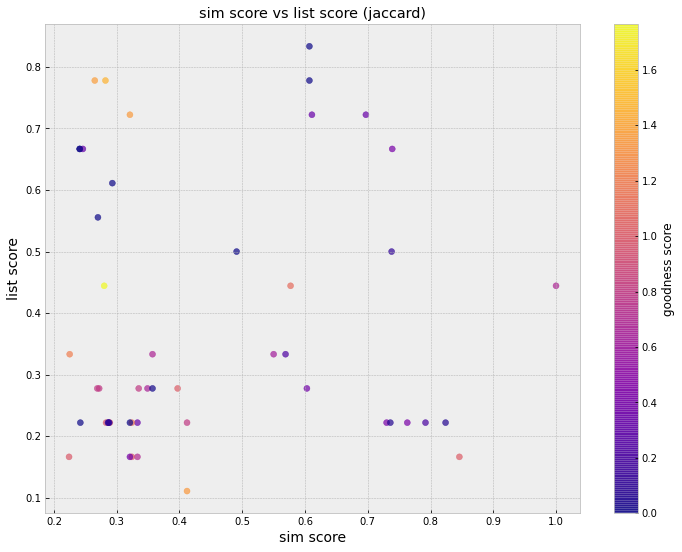

In [404]:
plot(algo, jaccard_sim_results_df, 'sim score', 'list score', color='goodness score')

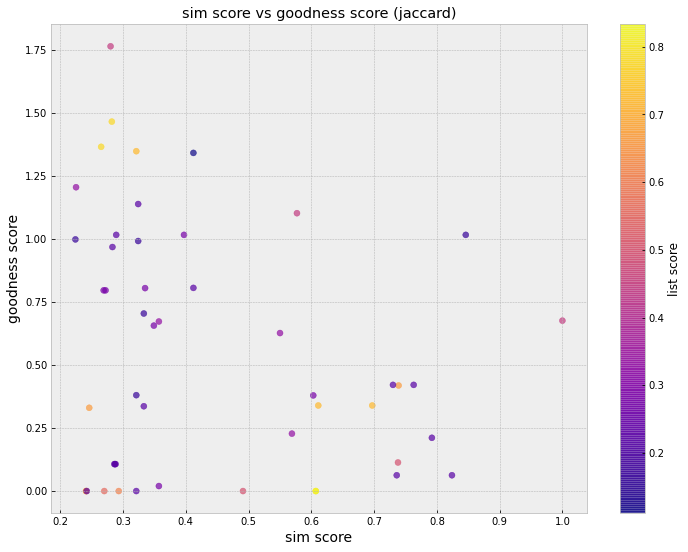

In [405]:
plot(algo, jaccard_sim_results_df, 'sim score', 'goodness score', color='list score')

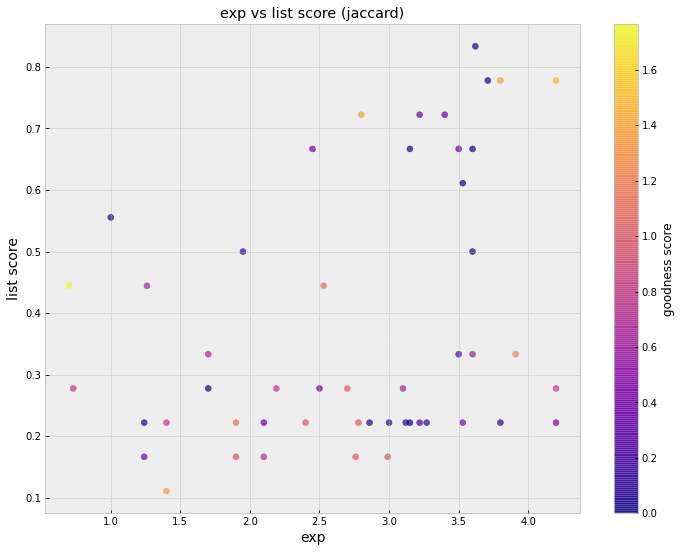

In [406]:
plot(algo, jaccard_sim_results_df, target, 'list score', color='goodness score')

<h2>Hyer Control Smiles</h2>

In [407]:
algo = 'hyer'
hyer_results_df = process_control_smiles(dataset, target, algo, results_dir)
hyer_results_df

,control_smiles,exp,list_score,goodness_score,percent_right,percent_top_3
0,Clc1cc(Nc2ncnc3[nH]nc(OCCN4CCCC4)c23)ccc1OCc1c...,2.87,0.744444,0.219714,0.4,0.6
1,CCN(CC)c1ccc(-c2nn3c(-c4[nH]nc5c4CCC5)nnc3s2)cc1,3.37,0.611111,0.520560,0.4,0.8
2,O=C(O)C[C@@H]1c2ccccc2C[C@H]1NC(=O)c1cc2cc(Cl)...,1.79,0.411111,0.549639,0.0,0.0
3,Cn1c(=O)c(Oc2ccc(F)cc2F)cc2cnc(NC(CCO)CCO)nc21,1.50,0.288889,0.803939,0.2,0.2
4,C[C@H](CO)Nc1nc(SCc2ccco2)nc2[nH]c(=O)sc12,2.21,0.222222,0.236024,0.0,0.0
5,C(#Cc1n[nH]c2ccccc12)c1ccccc1,4.31,0.611111,0.896255,0.4,0.8
6,CCCCCSc1nc(O)c2sc(N)nc2n1,2.86,0.244444,0.271502,0.0,0.0
7,NC(=O)NC(=O)C(Nc1ccc2c(c1)CCC2)c1ccccc1,3.30,0.244444,0.591136,0.2,0.2
8,CCOC(=O)c1cc(O)c(-c2ccccc2)nn1,0.69,0.255556,0.759744,0.2,0.2
9,NC(=O)NC(=O)C(Nc1ccc2c(c1)CCC2)c1ccccc1,3.30,0.177778,0.688061,0.0,0.0


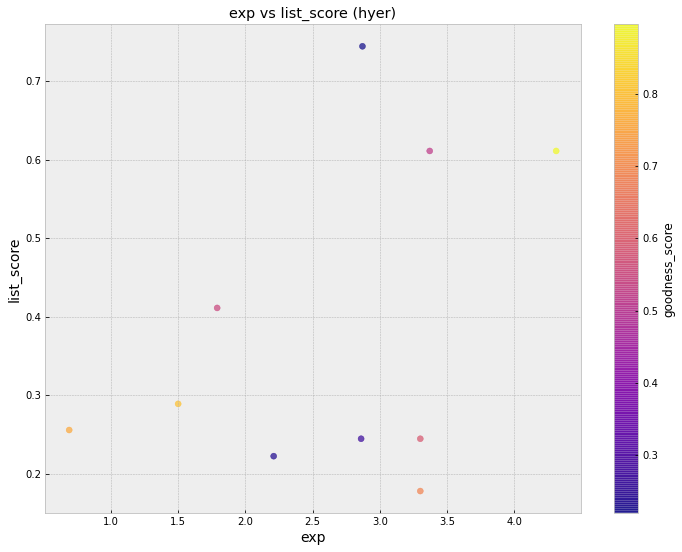

In [408]:
plot(algo, hyer_results_df, target, 'list_score', color='goodness_score')

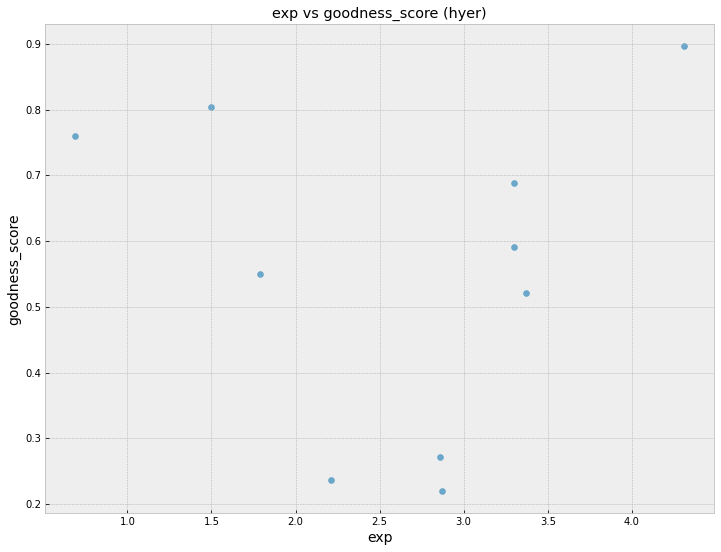

In [409]:
plot(algo, hyer_results_df, target, 'goodness_score', color=None)

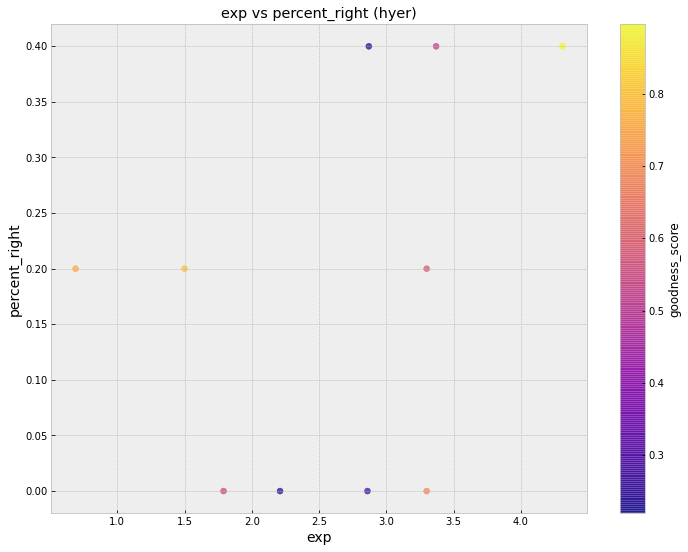

In [410]:
plot(algo, hyer_results_df, target, 'percent_right', color='goodness_score')

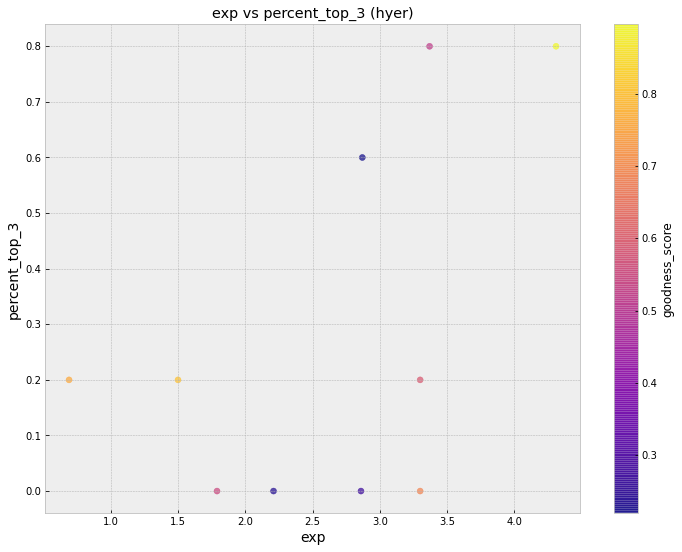

In [411]:
plot(algo, hyer_results_df, target, 'percent_top_3', color='goodness_score')

<h2>Hyer Testing Smiles</h2>

In [412]:
algo = 'hyer'
hyer_sim_results_df = process_sim_smiles(dataset, target, algo, results_dir)
hyer_sim_results_df.head(20)

,test_smiles,exp,sim score,list score,goodness score
0,O=C(CO)N1CCC[C@@H]1COc1cccc2ncnc(Nc3ccc(OCc4cc...,3.71,0.755,0.777778,0.000000
1,O=C(CO)N1CCC[C@H]1COc1cccc2ncnc(Nc3ccc(OCc4ccc...,3.62,0.755,0.833333,0.000000
2,Cc1ccc(Oc2ccc(Nc3ncnc4[nH]nc(OCCN5CCC(O)CC5)c3...,3.40,0.821,0.722222,0.339720
3,C[C@H](CN(C)C(=O)CO)Oc1cccc2ncnc(Nc3ccc(OCc4cc...,3.22,0.758,0.722222,0.339720
4,CN1CCN(CCOc2n[nH]c3ncnc(Nc4ccc(OCc5ccccn5)c(Cl...,2.45,0.850,0.666667,0.419130
5,CCc1nn(C2CCCC2)c2c1CCn1c(-c3cccs3)nnc1-2,3.60,0.389,0.666667,0.000000
6,CNc1ccc(-c2nc3ccc(O)cc3s2)cc1,3.50,0.395,0.666667,0.330590
7,c1ccc(-c2nnc3ccc(NC4CC4)nn23)cc1,3.15,0.388,0.666667,0.000000
8,NS(=O)(=O)c1ccc(CCNc2ccc3nnc(-c4ccccc4)n3n2)cc1,2.19,0.502,0.277778,0.805598
9,c1ccc(-c2nnc(-c3ccccc3)s2)cc1,4.20,0.440,0.777778,1.466612


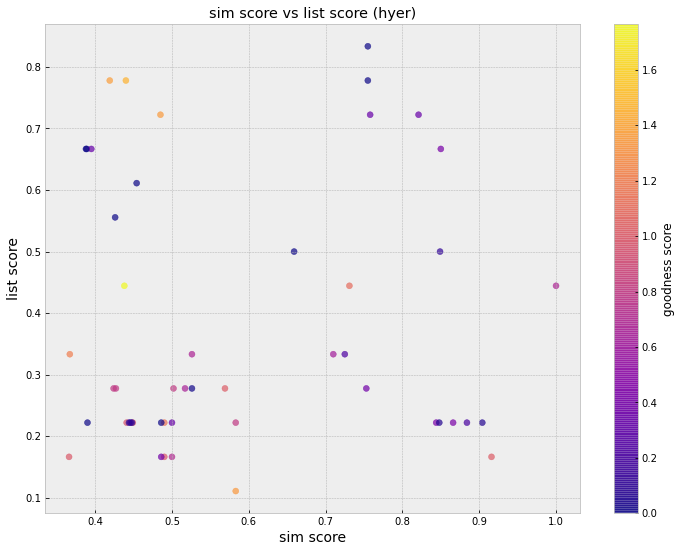

In [413]:
plot(algo, hyer_sim_results_df, 'sim score', 'list score', color='goodness score')

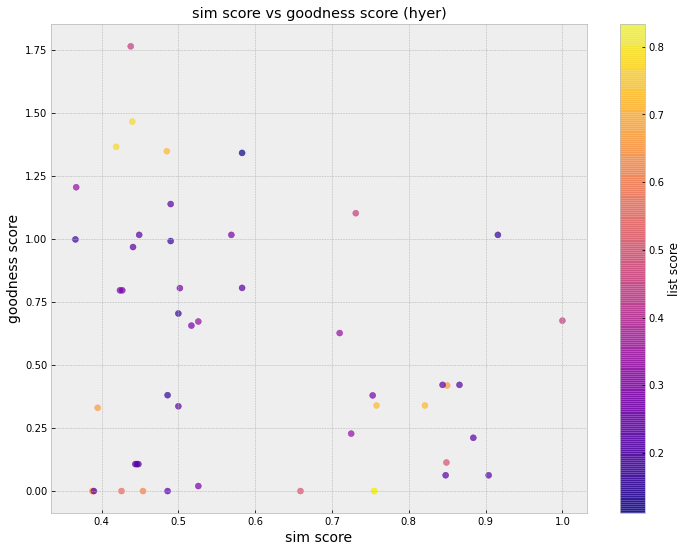

In [414]:
plot(algo, hyer_sim_results_df, 'sim score', 'goodness score', color='list score')

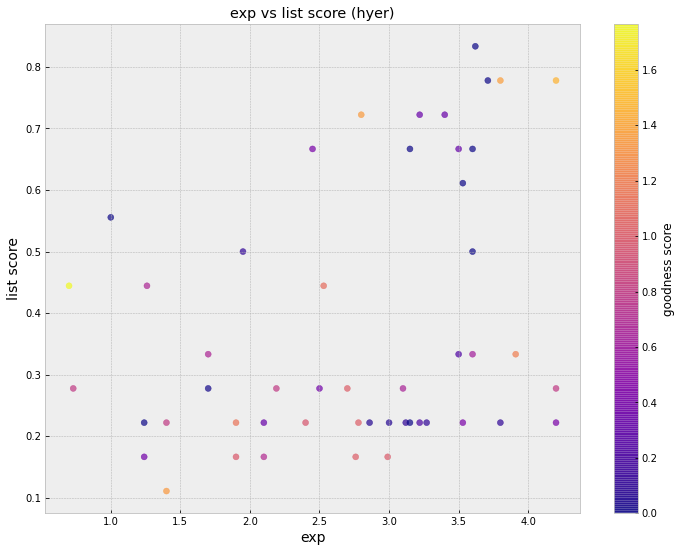

In [415]:
plot(algo, hyer_sim_results_df, target, 'list score', color='goodness score')